In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


mount gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip" -d "/content/Dataset"

Archive:  /content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip
   creating: /content/Dataset/Cats and Dogs Breed Clasification/test/
   creating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_141.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_142.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_143.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_144.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_145.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_146.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_148.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasificatio

In [ ]:
import os

BASE_DIR = '/content/Dataset/Cats and Dogs Breed Clasification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [ ]:
# Checking the downloaded file
len(os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian'))

70

In [ ]:
len(os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/train/Abyssinian'))

133

Import libraries

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
train_path = '/content/Dataset/Cats and Dogs Breed Clasification/train'
test_path = '/content/Dataset/Cats and Dogs Breed Clasification/test'

# Datagen for training set
train_datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=20, 
   width_shift_range=0.2, 
   height_shift_range=0.2,
   shear_range=0.2, 
   horizontal_flip=True, 
   zoom_range=0.2
)

# ImageDataGenerator for val
val_datagen = ImageDataGenerator(rescale=1./255)

# Let's try with 224, 224
IMG_SIZE = (224, 224)

# Create train dataset
train_set = train_datagen.flow_from_directory(directory=train_path, 
                                        batch_size= 32,
                                        class_mode='categorical',
                                        target_size=IMG_SIZE,
                                        color_mode='rgb')

# Create validation dataset
val_set = val_datagen.flow_from_directory(directory=test_path, 
                                        class_mode='categorical', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE,
                                        color_mode='rgb')


motives_dict = train_set.class_indices
print(motives_dict)

Found 1300 images belonging to 10 classes.
Found 700 images belonging to 10 classes.
{'Abyssinian': 0, 'Beagle': 1, 'Bombay': 2, 'British Shorthair': 3, 'Chihuahua': 4, 'Persian': 5, 'Pomeranian': 6, 'Pug': 7, 'Shiba Inu': 8, 'Siamese': 9}


In [ ]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [ ]:
# Print train shape and test shape

print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('val X=%s Y=%s' %(X_val.shape, y_val.shape))

Train X=(32, 224, 224, 3) Y=(32, 10)
val X=(32, 224, 224, 3) Y=(32, 10)


Use Transfer Learning as Feature Extractor
**bold text**

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


**Learning Rate Scheduler**

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Hyperparameters

In [ ]:
EPOCHS = 30
LEARNING_RATE = 1e-4
TRAIN_STEP = 1300//32
VAL_STEP = 700//32

**Train The Model**

In [ ]:
clear_session()

model = Sequential([
    base_model,
    Dense(150, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.25),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_set,
    validation_data=val_set,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 150)               192150    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                2265      
                                                                 
Total params: 2,452,399
Trainable params: 194,415
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/30


InvalidArgumentError: ignored

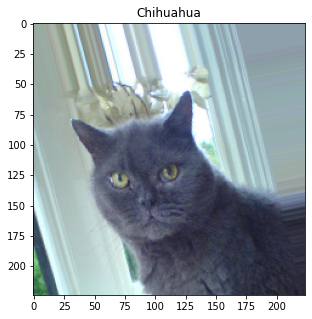

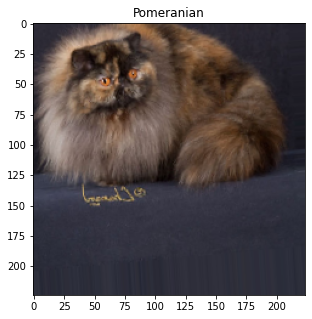

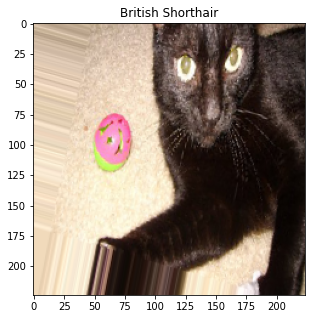

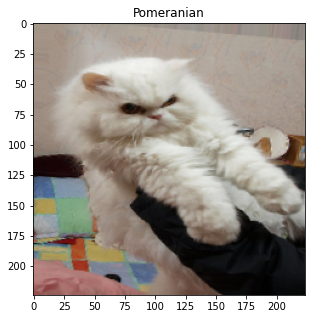

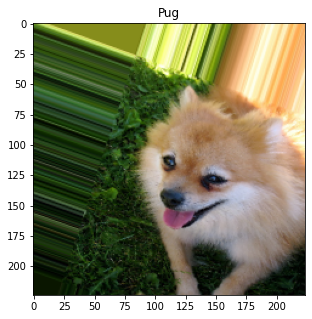

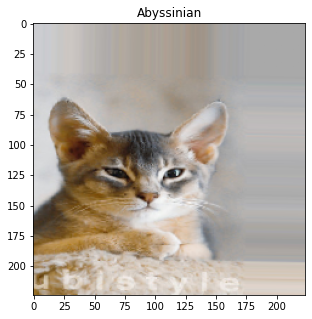

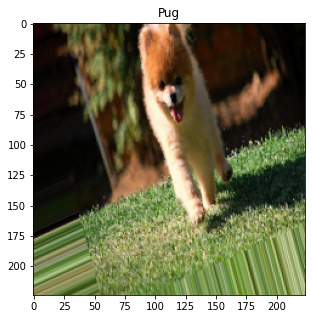

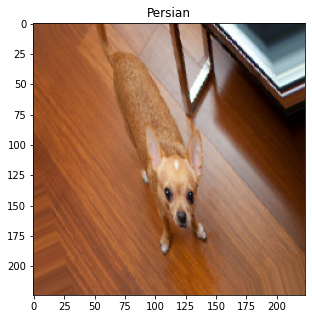

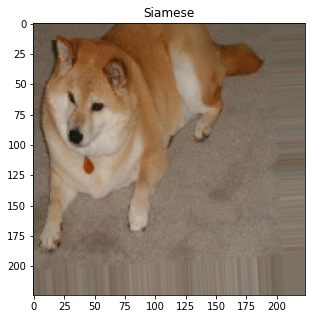

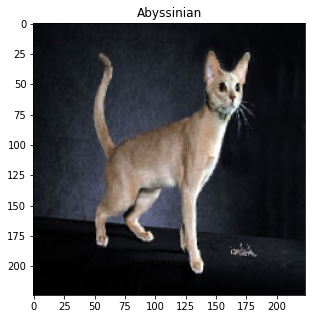

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels=[]
curr_y_train = np.argmax(y_train, axis=1)
# ['Abyssinian', 'Beagle','Bombay','British Shorthair', 'Chihuahua','Persian', 'Pomeranian', 'Pug', 'Shiba Inu','Siamese']
for label in curr_y_train:
  if label == 0:
    labels.append('Abyssinian')
  elif label == 1:
    labels.append('Beagle')
  elif label == 2:
    labels.append('British Shorthair')
  elif label == 3:
    labels.append('Chihuahua')
  elif label == 4:
    labels.append('Persian')
  elif label == 5:
    labels.append('Pomeranian')
  elif label == 6:
    labels.append('Pug')
  elif label == 7:
    labels.append('Shiba Inu')
  else:
    labels.append('Siamese')



for idx in range(0,10):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_train[idx])
    plt.title(labels[idx])

**Building the model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.callbacks import TensorBoard
import datetime
# Define Callbacks

## Callbacks when accuracy got 93% or above, the model will stop early
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.93 and logs.get('val_accuracy') >= 0.93) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False

## This function is for adjust the learning rate using exponential_decay
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 **(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)
custom_cb = CustomCallback()
# Define checkp point

checkpoint_cb = ModelCheckpoint("current_best_model.h5", saved_best_only=True)
early_stop_cb = EarlyStopping(patience=10, restore_best_weights= True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, 
                                                  histogram_freq=1)
# Clear any logs from previous runs
!rm -rf ./logs/ 

callbacks = [custom_cb, checkpoint_cb, early_stop_cb, lr_scheduler, tensorboard_callback]

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [ ]:
# Define xception based Model using 224, 224 input image and pooling max
xception_based_model = Xception(weights='imagenet', input_shape=(224, 224 ,3), include_top=False, pooling='max')
x = xception_based_model.output

# Define the MLP for classification
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(10, activation='softmax')(x)

# Define the model
model = Model(inputs=xception_based_model.input, outputs = predictions)

# freeze all layer in xception_based_model for training process,
for layer in xception_based_model.layers:
  layer.trainable = False
optimizer=Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Trains for 4 epochs
hist = model.fit(train_set, epochs=4, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/4
41/41 [==============================] - ETA: 0s - loss: 7.9200 - accuracy: 0.8177

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the current model

print('Loss of the model is - ', model.evaluate(X_test, y_test)[0])
print('Accuracy of the model is - ', model.evaluate(X_test, y_test)[1]*100, '%')

predict = model.predict(X_test)
# print(predict)
predict = np.argmax(predict, axis=1)
predict = predict.reshape(1, -1)[0]

curr_y_test = np.argmax(y_test, axis=1)


from sklearn.metrics import classification_report

print(classification_report(curr_y_test, predict, target_names =['Abyssinian', 'Beagle','Bombay','British Shorthair', 'Chihuahua','Persian', 'Pomeranian', 'Pug', 'Shiba Inu','Siamese']))

2/2 [==============================] - 12s 6s/step - loss: 3.8795 - accuracy: 0.9062
Loss of the model is -  3.8795459270477295
2/2 [==============================] - 12s 6s/step - loss: 3.8795 - accuracy: 0.9062
Accuracy of the model is -  90.625 %
                   precision    recall  f1-score   support

       Abyssinian       0.78      1.00      0.88         7
           Beagle       1.00      1.00      1.00         7
           Bombay       0.83      1.00      0.91         5
British Shorthair       1.00      0.50      0.67         6
        Chihuahua       1.00      0.83      0.91         6
          Persian       0.88      1.00      0.93         7
       Pomeranian       1.00      0.75      0.86         8
              Pug       1.00      1.00      1.00         6
        Shiba Inu       0.75      1.00      0.86         6
          Siamese       1.00      1.00      1.00         6

         accuracy                           0.91        64
        macro avg       0.92      0.91  

In [ ]:

optimizer=Adam()

# unfreeze last 10 layers and include them in training process
for layer in xception_based_model.layers[-10:]:
  layer.trainable=True
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
# Retrain the model with 100 epochs
hist = model.fit(train_set, epochs=50, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/50
21/21 [==============================] - 471s 23s/step - loss: 5.4954 - accuracy: 0.8146 - val_loss: 758.7922 - val_accuracy: 0.3327 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 4.9825 - accuracy: 0.9046 

KeyboardInterrupt: ignored